# Floating Array Design Project, Deep Case, Humboldt

## Imports and Styling

In [1]:
from time import perf_counter
from pathlib import Path

import pandas as pd

from waves import Project
from waves.utilities import load_yaml

# Update core Pandas display settings
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Configuration

First, we need to set the library path, and then we'll load the configuration file, to show some of
the configurations. For a complete guide and definition, please see either the
[API documentation](https://nrel.github.io/WAVES/api.html) or the
[How to use WAVES guide](https://nrel.github.io/WAVES/getting_started.html#configuring).

In [2]:
library_path = Path("../library/FAD/")
config_floating = load_yaml(library_path / "project/config", "base_floating_deep.yaml")

# This example was designed prior to the FLORIS 3.6 release, so the path to the turbine library in
# FLORIS must be manually updated, but this example must work for all users, so a dynamic method
# is used below, ensuring this works for all users.
config_floating["floris_config"] = load_yaml(library_path / "project/config", config_floating["floris_config"])

config_floating["floris_config"]["farm"]["turbine_library_path"] = library_path / "turbines"

Now, we'll create a Project for each of the fixed bottom and floating offshore scenarios, showing
the time it takes to initialize each project. Note that we're initializing using the
`Project.from_dict()` `classmethod` because the configurations are designed to also work with the
WAVES command line interface (CLI).

In [3]:
# Add in the library path for both configurations
config_floating.update({"library_path": library_path,})



start2 = perf_counter()

project_floating = Project.from_dict(config_floating)
1
end2 = perf_counter()
print(f"Floating loading time: {(end2-start2):,.2f} seconds")

'H' is deprecated and will be removed in a future version, please use 'h' instead.

ORBIT library intialized at 'C:\iea49\WAVES\library\FAD'
Floating loading time: 6.68 seconds


Missing data in columns ['bury_speed']; all values will be calculated.

### Visualize the wind farm

Both projects use the same layout, so we'll plot just the fixed bottom plant, noting that the self-connected line at the "OSS1" indicates the unmodeled interconnection point via a modeled export cable.

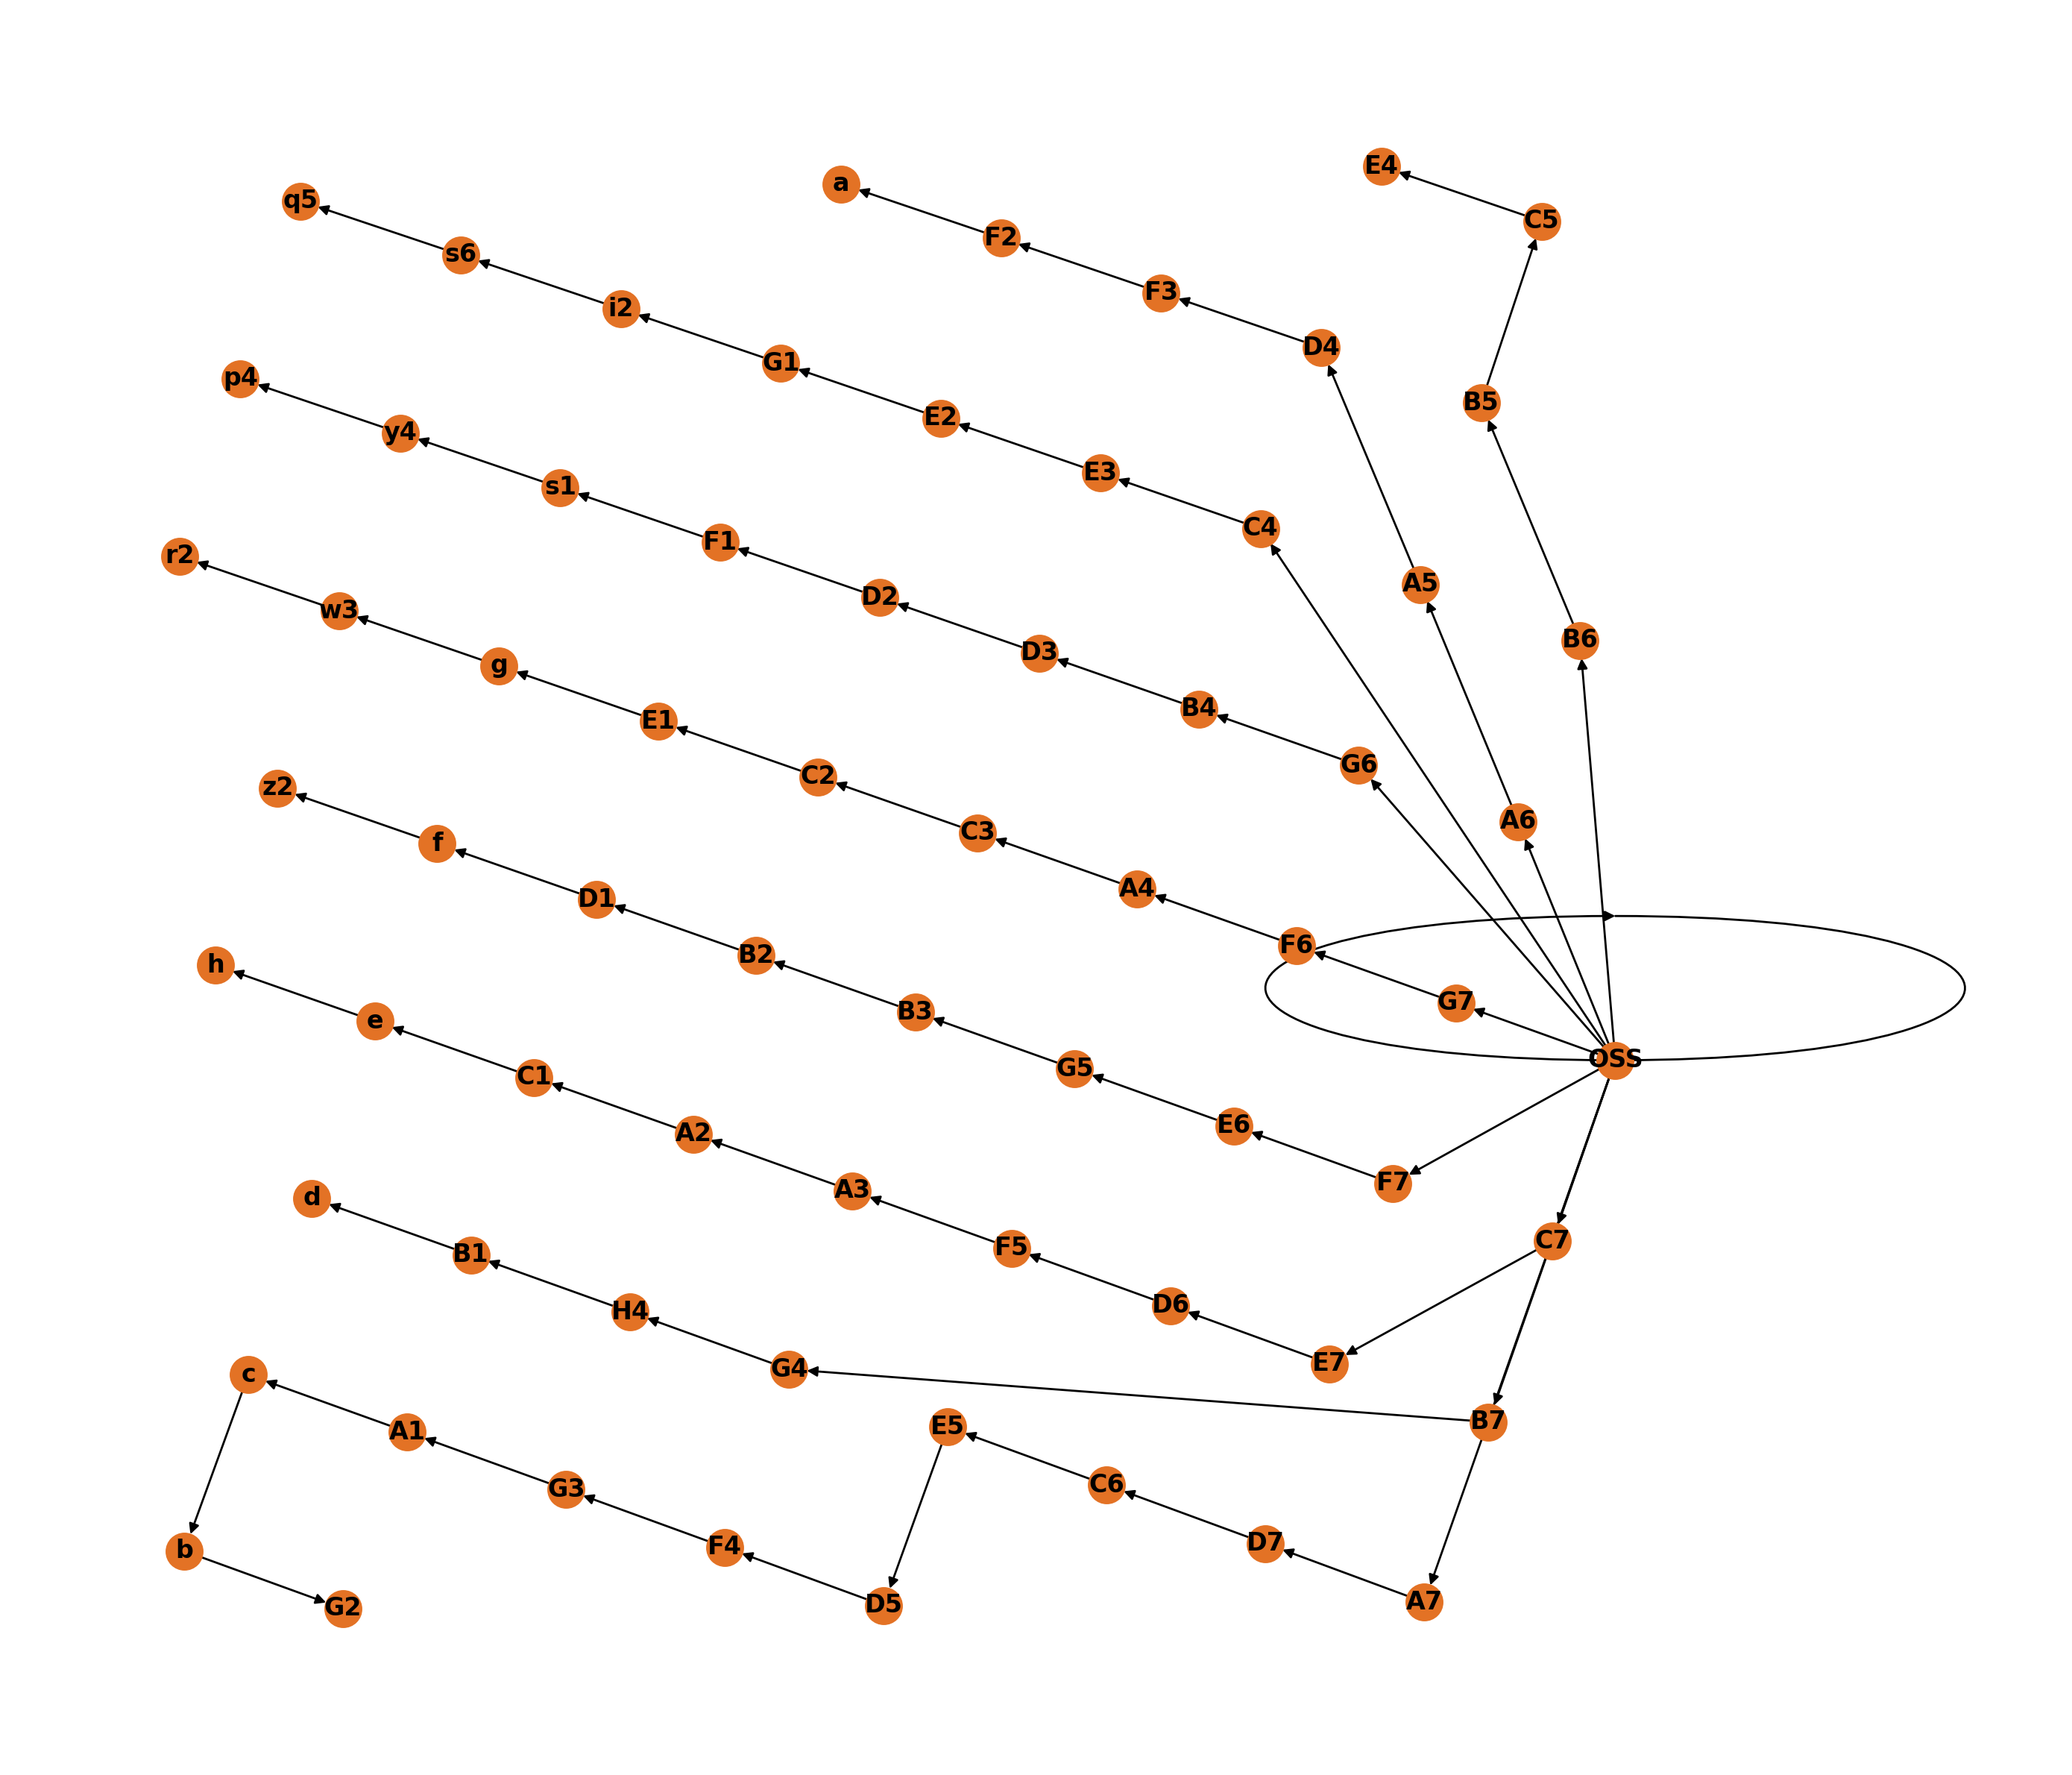

In [4]:
project_floating.plot_farm()

## Run the Projects

Now we'll, run all both the fixed-bottom and floating offshore wind scenarios. Notice that there are
additional parameters to use for running the FLORIS model in WAVES: `"wind_rose"` and
`"time_series"`. While time series is more accurate, it can take multiple hours to run for a
20-year, hourly timeseries, and lead to similar results, so we choose the model that will take only
a few minutes to run, instead.

Additionally, the wind rose can be computed based on the full weather profile,
`full_wind_rose=True`, for little added computation since WAVES computes a wind rose for each month
of the year, for a more accurate energy output. However, we're using just the weather profile used
in the O&M phase: `full_wind_rose=False`.

In [5]:
start2 = perf_counter()
project_floating.run(
    which_floris="wind_rose",
    full_wind_rose=False,
    floris_reinitialize_kwargs=dict(cut_in_wind_speed=3.0, cut_out_wind_speed=25.0)
)
project_floating.wombat.env.cleanup_log_files()  # Delete logging data from the WOMBAT simulations
end2 = perf_counter()

print("-" * 29)  # separate our timing from the ORBIT and FLORIS run-time warnings
print(f"Floating run time: {end2 - start2:,.2f} seconds")

Missing data in columns ['bury_speed']; all values will be calculated.

Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
Correcting negative Overhang:-2.5
-----------------------------
Floating run time: 270.26 seconds


In [6]:
df = pd.DataFrame(project_floating.orbit.phases["MooringSystemInstallation"].env.actions)
display(df)

,cost_multiplier,agent,action,duration,cost,level,time,phase,phase_name
0,1.00,Mooring System Installation Vessel,Mobilize,168.00,"1,050,000.00",ACTION,0.00,MooringSystemInstallation,NaN
1,NaN,Mooring System Installation Vessel,Load Mooring System,5.00,"31,250.00",ACTION,5.00,MooringSystemInstallation,MooringSystemInstallation
2,NaN,Mooring System Installation Vessel,Load Mooring System,5.00,"31,250.00",ACTION,10.00,MooringSystemInstallation,MooringSystemInstallation
3,NaN,Mooring System Installation Vessel,Load Mooring System,5.00,"31,250.00",ACTION,15.00,MooringSystemInstallation,MooringSystemInstallation
4,NaN,Mooring System Installation Vessel,Load Mooring System,5.00,"31,250.00",ACTION,20.00,MooringSystemInstallation,MooringSystemInstallation
...,...,...,...,...,...,...,...,...,...
895,NaN,Mooring System Installation Vessel,Install Mooring Line,4.00,"25,000.00",ACTION,"6,614.90",MooringSystemInstallation,MooringSystemInstallation
896,NaN,Mooring System Installation Vessel,Position Onsite,2.00,"12,500.00",ACTION,"6,616.90",MooringSystemInstallation,NaN
897,NaN,Mooring System Installation Vessel,Perform Mooring Site Survey,4.00,"25,000.00",ACTION,"6,620.90",MooringSystemInstallation,MooringSystemInstallation
898,NaN,Mooring System Installation Vessel,Install Suction Pile Anchor (IEA 49),15.00,"93,750.00",ACTION,"6,635.90",MooringSystemInstallation,MooringSystemInstallation


Both of these examples can also be run via the CLI, though the FLORIS `turbine_library_path`
configuration will have to be manually updated in each file to ensure the examples run.

```console
waves path/to/library/base_2022/ base_fixed_bottom_2022.yaml base_floating_bottom_2022.yaml --no-save-report
```

(example_cower_2022:results)=
## Gather the results

Another of the conveniences with using WAVES to run all three models is that some of the core
metrics are wrapped in the `Project` API, with the ability to generate a report of a selection of
the metrics.

Below, we define the inputs for the report by the following paradigm, where the `"metric"` and
`"kwargs"` keys must not be changed to ensure their values are read correctly. See the following
setup for details.

```python
configuration_dictionary = {
    "Descriptive Name of Metric": {
        "metric": "metric_method_name",
        "kwargs": {
            "metric_kwarg_1": "kwarg_1_value", ...
        }
    }
}
```

Below, it can be seen that many metrics do not have the `"kwargs"` dictionary item. This is because
an empty dictionary can be assumed to be used when no values need to be configured. In other words,
the default method configurations will be relied on, if not otherwise specified.

In [7]:
metrics_configuration = {
    "# Turbines": {"metric": "n_turbines"},
    "Turbine Rating (MW)": {"metric": "turbine_rating"},
    "Project Capacity (MW)": {
        "metric": "capacity",
        "kwargs": {"units": "mw"}
    },
    "# OSS": {"metric": "n_substations"},
    "Total Export Cable Length (km)": {"metric": "export_system_total_cable_length"},
    "Total Array Cable Length (km)": {"metric": "array_system_total_cable_length"},
    "CapEx ($)": {"metric": "capex"},
    "CapEx per kW ($/kW)": {
        "metric": "capex",
        "kwargs": {"per_capacity": "kw"}
    },
    "OpEx ($)": {"metric": "opex"},
    "OpEx per kW ($/kW)": {"metric": "opex", "kwargs": {"per_capacity": "kw"}},
    "AEP (MWh)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "aep": True, "with_losses": True}
    },
    "AEP per kW (MWh/kW)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "per_capacity": "kw", "aep": True, "with_losses": True}
    },
    "Net Capacity Factor With Wake Losses (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net"}
    },
    "Net Capacity Factor With All Losses (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net", "with_losses": True}
    },
    "Gross Capacity Factor (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "gross"}
    },
    "Energy Availability (%)": {
        "metric": "availability",
        "kwargs": {"which": "energy"}
    },
    "LCOE ($/MWh)": {"metric": "lcoe"},
}


# Define the final order of the metrics in the resulting dataframes
metrics_order = [
    "# Turbines",
    "Turbine Rating (MW)",
    "Project Capacity (MW)",
    "# OSS",
    "Total Export Cable Length (km)",
    "Total Array Cable Length (km)",
    "FCR (%)",
    "Offtake Price ($/MWh)",
    "CapEx ($)",
    "CapEx per kW ($/kW)",
    "OpEx ($)",
    "OpEx per kW ($/kW)",
    "Annual OpEx per kW ($/kW)",
    "Energy Availability (%)",
    "Gross Capacity Factor (%)",
    "Net Capacity Factor With Wake Losses (%)",
    "Net Capacity Factor With All Losses (%)",
    "AEP (MWh)",
    "AEP per kW (MWh/kW)",
    "LCOE ($/MWh)",
]

capex_order = [
    "Array System",
    "Export System",
    "Offshore Substation",
    "Substructure",
    "Scour Protection",
    "Mooring System",
    "Turbine",
    "Array System Installation",
    "Export System Installation",
    "Offshore Substation Installation",
    "Substructure Installation",
    "Scour Protection Installation",
    "Mooring System Installation",
    "Turbine Installation",
    "Soft",
    "Project",
]

Before we generate the report, let's see a CapEx breakdown of each scenario. To do this, we'll
access ORBIT's `ProjectManager` object directly to access model-specific functionality. This is
available for each model via:

- `project.orbit`: provides access to ORBIT's `ProjectManager`
- `project.wombat` provides access to WOMBAT's `Simulation`
- `project.floris` provides access to FLORIS's `FlorisInterface`

In [8]:
# Capture the CapEx breakdown from each scenario

df_capex_floating = pd.DataFrame(
    project_floating.orbit.capex_breakdown.items(),
    columns=["Component", "CapEx ($) - Floating"]
)


df_capex_floating["CapEx ($/kW) - Floating"] = df_capex_floating["CapEx ($) - Floating"] / project_floating.capacity("kw")

df_capex_floating

,Component,CapEx ($) - Floating,CapEx ($/kW) - Floating
0,Array System,"1,073,429,299.54","1,068.09"
1,Export System,"293,277,216.78",291.82
2,Substructure,"984,432,572.82",979.53
3,Mooring System,"164,283,732.00",163.47
4,Offshore Substation,"154,546,456.67",153.78
5,Array System Installation,"1,370,799,432.36","1,363.98"
6,Export System Installation,"107,254,283.09",106.72
7,Substructure Installation,"316,588,620.39",315.01
8,Mooring System Installation,"65,922,108.76",65.59
9,Offshore Substation Installation,"5,209,630.15",5.18


Now, let's generate the report, and then add in some additional reporting variables.

In [9]:
project_name_floating = "FAD Deep Case - Floating"

# Generate the reports using WAVES and the above configurations
# NOTE: the results are transposed to view them more easily for the example, otherwise
# each row would be a project, which is helpful for combining the results of many scenarios
report_df_floating = project_floating.generate_report(metrics_configuration, project_name_floating).T

# Gather some additional metadata and results from the projects
n_years_floating = project_floating.operations_years

additional_reporting_floating = pd.DataFrame(
    [
        ["FCR (%)", project_floating.fixed_charge_rate],
        ["Offtake Price ($/MWh)", project_floating.offtake_price],
        [
            "Annual OpEx per kW ($/kW)",
            report_df_floating.loc["OpEx per kW ($/kW)", project_name_floating] / n_years_floating
        ],
    ],
    columns=["Project"] + report_df_floating.columns.tolist(),
).set_index("Project")

# Combine the additional metrics to the generated report
report_df_floating = pd.concat((report_df_floating, additional_reporting_floating), axis=0).loc[metrics_order]

# Combine both reports into one, easy to view dataframe
report_df = report_df_floating
report_df.index.name = "Metrics"

# Format percent-based rows to show as such, not as decimals
report_df.loc[report_df.index.str.contains("%")] *= 100

report_df

,FAD Deep Case - Floating
Metrics,
# Turbines,67.00
Turbine Rating (MW),15.00
Project Capacity (MW),"1,005.00"
# OSS,1.00
Total Export Cable Length (km),206.53
Total Array Cable Length (km),"2,683.57"
FCR (%),6.48
Offtake Price ($/MWh),83.30
CapEx ($),"7,114,068,352.56"
